In [1]:
from tqdm import trange

import numpy as np
from scipy.sparse.linalg import eigs

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.use('pgf')
mpl.rcParams.update({
    'text.usetex': True,
    'pgf.texsystem': 'pdflatex',
})

In [3]:
from rsnn.rand import rand_connections_fin, rand_connections_fout

In [4]:
%matplotlib inline

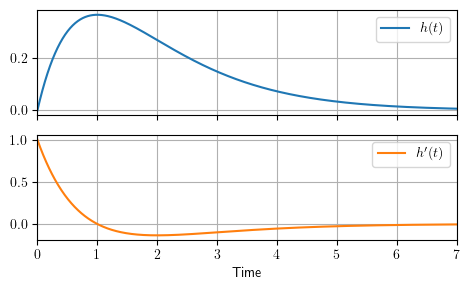

In [5]:
h = lambda t_: (t_ >= 0.0) * t_ * np.exp(-t_)
hp = lambda t_: (t_ >= 0.0) * (1.0 - t_) * np.exp(-t_)

fig, axes = plt.subplots(2, 1, figsize=(4.8, 3), sharex=True)

axes[-1].set_xlabel('Time')
axes[-1].set_xlim(0.0, 7.0)
axes[0].grid()
axes[1].grid()
# axes[1].set_ylabel('$h\'(t)$')

t = np.linspace(0.0, 7.0, 1000)
axes[0].plot(t, h(t), c='C0', label='$h(t)$')
axes[1].plot(t, hp(t), c='C1',label='$h\'(t)$')

axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.savefig('impulse_responses.pdf')

# Jitter Propagation

In [6]:
np.random.seed(42)

M = 10
m = 3

B = np.random.randn(M, M)
A = np.random.randn(M, M)
A = A / np.sum(A, axis=1, keepdims=True)

In [7]:
B = np.identity(M)
for m in range(M):
    B[m] = A[m] @ B
Bt = B - 1/M

In [8]:
eigvals_B = np.abs(np.linalg.eigvals(B))
eigvals_Bt = np.abs(np.linalg.eigvals(Bt))

In [18]:
M = 10

A = np.random.randn(M, M)
A = A / np.sum(A, axis=1, keepdims=True)

B = np.identity(M)
for m in range(M):
    B[m] = A[m] @ B
Bt = B - 1/M

phi = np.abs(eigs(Bt, k=1, which='LM', return_eigenvectors=False))
phi

array([1.15209829])

In [19]:
B = np.identity(M)
for m in range(M):
    B[m] = A[m] @ B
# Bt = B - 1/M

# phi = np.abs(eigs(Bt, k=1, which='LM', return_eigenvectors=False))
np.sort(np.abs(np.linalg.eigvals(B)))

array([0.00403421, 0.16343807, 0.16343807, 0.28178596, 0.54411984,
       0.54411984, 0.66074219, 1.        , 1.15209829, 1.15209829])

In [22]:
B = np.identity(M)
for m in range(M):
    B[m] = A[m] @ B
B -= 1/M

# phi = np.abs(eigs(Bt, k=1, which='LM', return_eigenvectors=False))
np.sort(np.abs(np.linalg.eigvals(B)))

array([6.13979248e-15, 4.03420687e-03, 1.63438070e-01, 1.63438070e-01,
       2.81785962e-01, 5.44119843e-01, 5.44119843e-01, 6.60742188e-01,
       1.15209829e+00, 1.15209829e+00])

In [10]:
# One needs to compute all am 
# Based on the previous spikes

# 1. Order firing times
# 2. The reference spike for the am vector is the mth spike
# 3. The coefficient of the am vector depends on the i) the previous M spikes and ii) the weights and delays of the connections transmitting these spikes
# 4. Select all spikes of which a delayed copy arrives in between the previous and the current spike of the current neuron
# 5. 


In [11]:
M = 7

In [12]:
# f_times is a list of np.array, one for each neuron
# f_times is an np.array with shape (M, 2): each row contains the neuron index and the firing time

f_sources = np.random.randint(0, M, size=M)
f_times = np.random.rand(M)
f_times, f_sources


(array([0.81290101, 0.99971767, 0.99663684, 0.55543171, 0.76898742,
        0.94476573, 0.84964739]),
 array([2, 6, 0, 4, 6, 5, 3]))

In [13]:
# sort rows by firing time
ids = np.argsort(f_times)
f_times = f_times[ids]
f_sources = f_sources[ids]
f_times, f_sources

(array([0.55543171, 0.76898742, 0.81290101, 0.84964739, 0.94476573,
        0.99663684, 0.99971767]),
 array([4, 6, 2, 3, 5, 0, 6]))

In [ ]:
rng = np.random.default_rng(42)

# connections
L, K = 100, 200
c_sources = rng.integers(0, L, size=(L, K))
c_delays = rng.uniform(0.0, 10.0, size=(L, K))
c_weights = rng.standard_normal(size=(L, K))

# nominal firing times
M = 1000
period = 50.0
f_sources = rng.integers(0, L, size=M)
f_times = rng.uniform(0.0, period, size=M)

# sort f_times and f_sources
ids = np.argsort(f_times)
f_sources = f_sources[ids]
f_times = f_times[ids]

In [18]:
Phi = np.identity(M)

for m in trange(M):
    f_source = f_sources[m]  # neuron index producing the m-th spike

    # views on the connections to the neuron producing the m-th spike
    sources = c_sources[f_source]
    weights = c_weights[f_source]
    delays = c_delays[f_source]

    # get the previous spike generated by the same neuron
    i = 1
    while f_sources[(m - i) % M] != f_sources[m]:
        i += 1
    prev_f_time = f_times[(m - i) % M]
    f_time = (f_times[m] - prev_f_time) % period

    am = np.zeros(M)
    for mi in range(M):
        # compute the contribution of the mi-th spike to the potential slope at the m-th spike
        f_source_i = f_sources[mi]
        select_from = sources == f_source_i
        in_f_times = (f_times[mi] + delays[select_from] - prev_f_time) % period
        in_weights = weights[select_from]

        am[mi] = np.sum(
            in_weights * (1 - (f_time - in_f_times)) * np.exp(-(f_time - in_f_times)),
            where=f_time >= in_f_times,
        )

    Phi[m] = am @ Phi

Phi -= 1/M

phi = np.abs(eigs(Phi, k=1, which='LM', return_eigenvectors=False))
print(f"phi = {phi}")

100%|██████████| 1000/1000 [00:22<00:00, 45.42it/s]

phi = [1.71909954e+08]


In [65]:
%%timeit

M = 2000

B = np.random.randn(M, M)
A = np.random.randn(M, M)
A = A / np.sum(A, axis=1, keepdims=True)

B = np.identity(M)
for m in range(M):
    B[m] = A[m] @ B
Bt = B - 1/M

phi = np.abs(sp.linalg.eigs(Bt, k=1, which='LM', return_eigenvectors=False))

2.67 s ± 24.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
%%timeit

M = 2000

B = np.random.randn(M, M)
A = np.random.randn(M, M)
A = A / np.sum(A, axis=1, keepdims=True)

B = np.identity(M)
for m in range(M):
    B[m] = A[m] @ B
Bt = B - 1/M

phi = np.max(np.abs(np.linalg.eigvals(Bt)))

9.14 s ± 781 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
eigvals_B, eigvals_Bt

(array([3.05921709e+00, 3.05921709e+00, 7.09214061e-01, 1.01508751e+00,
        1.01508751e+00, 2.73075795e-01, 2.73075795e-01, 1.21858405e-04,
        1.00000000e+00, 1.35864719e+00]),
 array([3.05921709e+00, 3.05921709e+00, 1.01508751e+00, 1.01508751e+00,
        1.35864719e+00, 7.09214061e-01, 2.73075795e-01, 2.73075795e-01,
        1.21858404e-04, 8.77769783e-13]))

In [ ]:
plt.scatter(eigvals_B.real, eigvals_B.imag, label='B')
plt.scatter(eigvals_Bt.real, eigvals_Bt.imag, label='Bt')
plt.legend()
plt.show()

In [32]:
A = np.identity(M)
A[m] = am

In [33]:
A @ B

array([[ 0.49671415, -0.1382643 ,  0.64768854, ..., -0.70531672,
         0.49576557,  0.64438845],
       [-0.67849473, -0.30549946, -0.59738106, ...,  0.37835397,
         1.71352973, -1.6199198 ],
       [ 0.34828625,  0.28332359, -0.93651985, ..., -0.50136732,
        -1.89235682, -0.22888421],
       ...,
       [ 0.5455244 ,  0.4162931 ,  1.05139367, ..., -0.01440908,
        -0.04915986,  1.3211534 ],
       [-0.92806894, -1.49895442,  1.41981357, ...,  1.32012764,
         0.71234184, -1.86161895],
       [-0.38387709,  1.47142402, -0.80106985, ..., -0.0184878 ,
        -0.18001784, -1.73699787]], shape=(10000, 10000))

In [8]:
np.allclose(B_copy_1, B_copy_2)

True